<a href="https://colab.research.google.com/github/ZizoHamoui/NEWS_NLP_CLASSIFIER_MODEL/blob/main/NLP_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install numpy torch datasets transformers evaluate --quiet

In [ ]:
!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126
transformers==4.57.2


##Importing Dataset and splitting

In [ ]:
from datasets import load_dataset

ds = load_dataset("AyoubChLin/CNN_News_Articles_2011-2022")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train_CNN_Article.csv:   0%|          | 0.00/186M [00:00<?, ?B/s]

test_CNN_Article.csv:   0%|          | 0.00/33.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32218 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5686 [00:00<?, ? examples/s]

In [ ]:
dataset = ds['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25774
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6444
    })
})

In [ ]:
dataset['val'] = dataset['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25774
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6444
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 6444
    })
})

In [ ]:
dataset['test'] = ds['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25774
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5686
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 6444
    })
})

In [ ]:
from datasets import DatasetDict

def is_good_example(example):
    return example["text"] is not None and isinstance(example["text"], str)

clean_dataset = DatasetDict({
    split: dataset[split].filter(is_good_example)
    for split in dataset.keys()
})

print(clean_dataset)

for split in clean_dataset.keys():
    print(f"{split} num_rows:", clean_dataset[split].num_rows)

Filter:   0%|          | 0/25774 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6444 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25769
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5684
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 6442
    })
})
train num_rows: 25769
test num_rows: 5684
val num_rows: 6442


##Initializing Model and Evaluation Metrics

In [ ]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
from datasets import DatasetDict

working_dataset = clean_dataset if 'clean_dataset' in globals() else dataset

def tokenization(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=512,
        padding=False,
    )

tokenized_dataset = working_dataset.map(
    tokenization,
    batched=True,
    remove_columns=["text"],
)

tokenized_dataset


Map:   0%|          | 0/25769 [00:00<?, ? examples/s]

Map:   0%|          | 0/5684 [00:00<?, ? examples/s]

Map:   0%|          | 0/6442 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25769
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5684
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6442
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(
        predictions=preds,
        references=labels,
    )

    f1 = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="weighted",
    )

    return {
        "accuracy": acc["accuracy"],
        "f1_weighted": f1["f1"],
    }

print("compute_metrics redefined for multiclass (weighted F1).")


compute_metrics redefined for multiclass (weighted F1).


In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

checkpoint = 'distilbert-base-uncased'
num_labels = 6

id2label = {
    0: 'BUSINESS',
    1: 'ENTERTAINMENT',
    2: 'HEALTH',
    3: 'NEWS',
    4: 'POLITICS',
    5: 'SPORT',
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

os.environ['WANDB_DISABLED'] = "true"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2176754172.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.compute_metrics = compute_metrics

##Untrained Model Evaluation on Test

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 1.7639137506484985,
 'eval_model_preparation_time': 0.0013,
 'eval_accuracy': 0.4016537649542576,
 'eval_f1_weighted': 0.23289848033367777,
 'eval_runtime': 81.4559,
 'eval_samples_per_second': 69.78,
 'eval_steps_per_second': 4.37}

##Train Model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1 Weighted
1,0.175100,0.165867,0.001400,0.958088,0.956970
2,0.097800,0.167157,0.001400,0.959174,0.959413
3,0.052500,0.184658,0.001400,0.961658,0.960982


TrainOutput(global_step=4833, training_loss=0.12138229992087278, metrics={'train_runtime': 3946.9074, 'train_samples_per_second': 19.587, 'train_steps_per_second': 1.225, 'total_flos': 1.0241387698231296e+16, 'train_loss': 0.12138229992087278, 'epoch': 3.0})

##Evaluate Trained Model on Test

In [ ]:
!cp -r /content/results /content/drive/MyDrive/

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.1528778374195099,
 'eval_model_preparation_time': 0.0014,
 'eval_accuracy': 0.9600633356790992,
 'eval_f1_weighted': 0.9591856918279782,
 'eval_runtime': 85.3716,
 'eval_samples_per_second': 66.58,
 'eval_steps_per_second': 4.17,
 'epoch': 3.0}

## Save Trained Model

In [ ]:
save_dir = "cnn_news_bert_classifier"

trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model and tokenizer saved to: {save_dir}")

Model and tokenizer saved to: cnn_news_bert_classifier


In [ ]:
!cp -r /content/cnn_news_bert_classifier /content/drive/MyDrive/

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer

model_path = "/content/drive/MyDrive/cnn_news_bert_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

os.environ['WANDB_DISABLED'] = "true"

/tmp/ipython-input-2700216948.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.1528778225183487,
 'eval_model_preparation_time': 0.0014,
 'eval_accuracy': 0.9600633356790992,
 'eval_f1_weighted': 0.9591856918279782,
 'eval_runtime': 80.4259,
 'eval_samples_per_second': 70.674,
 'eval_steps_per_second': 8.84}

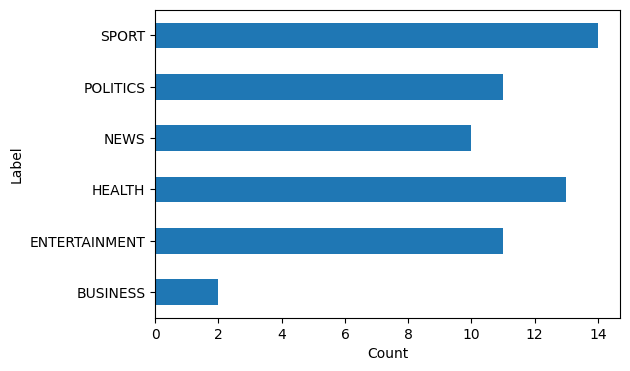

In [ ]:
import matplotlib.pyplot as plt

label_counts = results_df["true_label_name"].value_counts()

plt.figure(figsize=(6, 4))
label_counts.sort_index().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

In [ ]:
!pip install pandas openpyxl --quiet

import pandas as pd
from datasets import Dataset

In [ ]:
excel_path0 = "/content/drive/MyDrive/CNN_Test_Data.xlsx"

test_df0 = pd.read_excel(excel_path0)

print(test_df0.head())
print(test_df0.columns)

                                                Text     Label
0  LaMelo Ball has stuck with the Charlotte Horne...   sports 
1  CeeDee Lamb says he and fellow Dallas Cowboys ...   sports 
2  Baylor AD Mack Rhoades resigns, a week after t...   sports 
3  Trump renews effort to block states from regul...  politics
4  Bipartisan push to reform censure process emer...  politics
Index(['Text', 'Label'], dtype='object')


In [ ]:
display(results_df.head())

In [ ]:
print(results_df['pred_label'].unique())

In [ ]:
test_df0 = test_df0.dropna(subset=["Text", "Label"])

test_df0["Label_clean"] = test_df0["Label"].astype(str).str.strip().str.lower()

label_name_map = {
    "business": "BUSINESS",
    "entertainment": "ENTERTAINMENT",
    "health": "HEALTH",
    "news": "NEWS",
    "politics": "POLITICS",
    "sport": "SPORT",
    "sports": "SPORT",
}

test_df0["label_name"] = test_df0["Label_clean"].map(label_name_map)

unmapped = test_df0[test_df0["label_name"].isna()]["Label"].unique()
print("Unmapped label values (should be empty):", unmapped)

test_df0 = test_df0.dropna(subset=["label_name"])

test_df0["label"] = test_df0["label_name"].map(label2id)

test_df0[["Text", "Label", "Label_clean", "label_name", "label"]].head()


Unmapped label values (should be empty): []


,Text,Label,Label_clean,label_name,label
0,LaMelo Ball has stuck with the Charlotte Horne...,sports,sports,SPORT,5
1,CeeDee Lamb says he and fellow Dallas Cowboys ...,sports,sports,SPORT,5
2,"Baylor AD Mack Rhoades resigns, a week after t...",sports,sports,SPORT,5
3,Trump renews effort to block states from regul...,politics,politics,POLITICS,4
4,Bipartisan push to reform censure process emer...,politics,politics,POLITICS,4


In [ ]:
from datasets import Dataset

df_for_ds = test_df0.rename(columns={"Text": "text"})[["text", "label"]]

external_test_dataset0 = Dataset.from_pandas(
    df_for_ds,
    preserve_index=False,
)

external_test_dataset0


Dataset({
    features: ['text', 'label'],
    num_rows: 61
})

In [ ]:
tokenized_external_test0 = external_test_dataset0.map(
    tokenization,
    batched=True,
)

tokenized_external_test0


Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 61
})

##External Metrics Trained model

In [ ]:
external_metrics = trainer.evaluate(tokenized_external_test)
external_metrics

{'eval_loss': 0.6268568634986877,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9016393442622951,
 'eval_f1_weighted': 0.8990907551688637,
 'eval_runtime': 0.7255,
 'eval_samples_per_second': 84.074,
 'eval_steps_per_second': 11.026}

In [ ]:
import numpy as np

pred_output = trainer.predict(tokenized_external_test)
logits = pred_output.predictions
pred_ids = np.argmax(logits, axis=-1)

id2label = {v: k for k, v in label2id.items()}
pred_labels = [id2label[i] for i in pred_ids]
true_labels = [id2label[i] for i in df_for_ds["label"].tolist()]

results_df = test_df.copy()
results_df["pred_label"] = pred_labels
results_df["true_label_name"] = [id2label[i] for i in test_df["label"]]

results_df[["Text", "Label", "true_label_name", "pred_label"]].head(20)


,Text,Label,true_label_name,pred_label
0,LaMelo Ball has stuck with the Charlotte Horne...,sports,SPORT,SPORT
1,CeeDee Lamb says he and fellow Dallas Cowboys ...,sports,SPORT,SPORT
2,"Baylor AD Mack Rhoades resigns, a week after t...",sports,SPORT,SPORT
3,Trump renews effort to block states from regul...,politics,POLITICS,POLITICS
4,Bipartisan push to reform censure process emer...,politics,POLITICS,POLITICS
5,Judge halts Trump’s deployment of national gua...,politics,POLITICS,POLITICS
6,Colombia recovers first treasures from 300-yea...,news,NEWS,NEWS
7,‘Grey’s Anatomy’ star James Pickens Jr. opens ...,entertainment,ENTERTAINMENT,ENTERTAINMENT
8,Meryl Streep reunites with Anne Hathaway in ‘T...,entertainment,ENTERTAINMENT,ENTERTAINMENT
9,They’re making a sequel to ‘The Family Stone’\...,entertainment,ENTERTAINMENT,ENTERTAINMENT


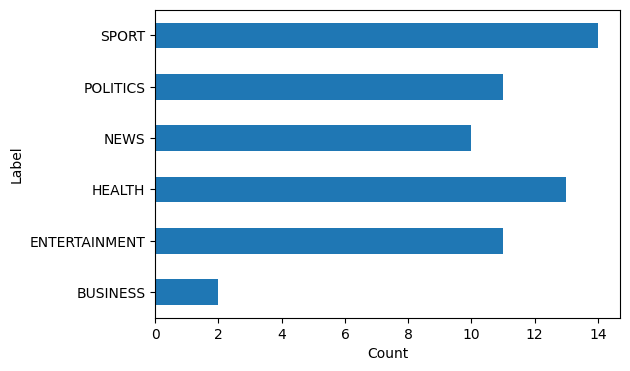

In [ ]:
import matplotlib.pyplot as plt

label_counts = results_df["true_label_name"].value_counts()

plt.figure(figsize=(6, 4))
label_counts.sort_index().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()


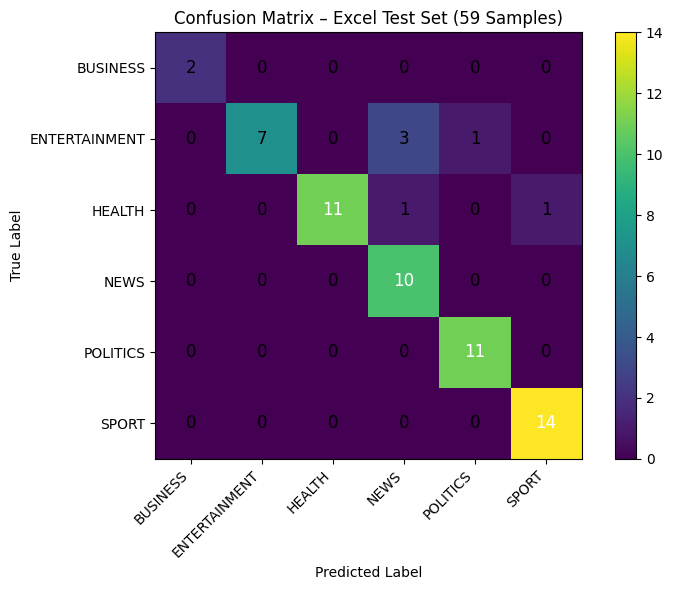

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true_labels, pred_labels, labels=list(label2id.keys()))
labels_sorted = list(label2id.keys())

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')

for i in range(len(labels_sorted)):
    for j in range(len(labels_sorted)):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=12)

ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45, ha="right")
ax.set_yticklabels(labels_sorted)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix – Excel Test Set (59 Samples)")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

class_names = list(label2id.keys())
num_classes = len(class_names)

y_true_bin = label_binarize(true_labels, classes=class_names)

probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)


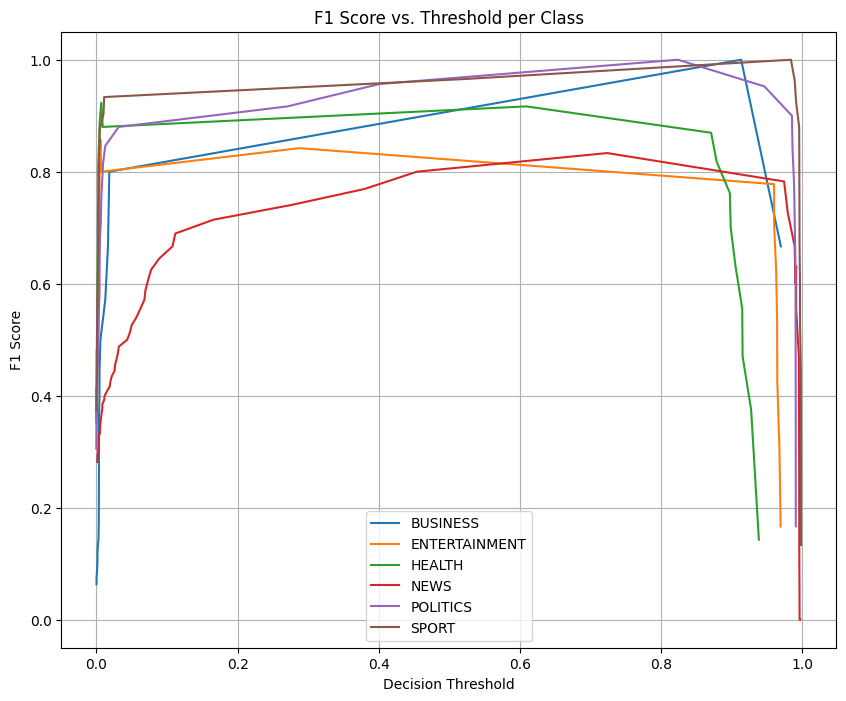

In [ ]:
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    precision, recall, thresholds = precision_recall_curve(y_true_bin[:, i], probs[:, i])

    f1 = (2 * precision * recall) / (precision + recall + 1e-9)

    plt.plot(thresholds, f1[:-1], label=class_name)

plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold per Class")
plt.legend()
plt.grid(True)
plt.show()

##External Data untrained model

In [ ]:
import pandas as pd
from datasets import Dataset

# Path where your Excel file is stored
excel_path = "/content/drive/MyDrive/CNN_Test_Data.xlsx"

df = pd.read_excel(excel_path)
df = df.dropna(subset=["Text", "Label"])

# Normalize label names
df["Label_clean"] = df["Label"].str.strip().str.lower()

label_name_map = {
    "business": "BUSINESS",
    "entertainment": "ENTERTAINMENT",
    "health": "HEALTH",
    "news": "NEWS",
    "politics": "POLITICS",
    "sport": "SPORT",
    "sports": "SPORT",
}

df["label_name"] = df["Label_clean"].map(label_name_map)
df = df.dropna(subset=["label_name"])

df["label"] = df["label_name"].map(label2id)

# HuggingFace dataset format
external_ds = Dataset.from_pandas(
    df.rename(columns={"Text": "text"})[["text", "label"]],
    preserve_index=False
)

In [ ]:
tokenized_external = external_ds.map(tokenization, batched=True)
tokenized_external


Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 61
})

In [ ]:
from transformers import AutoModelForSequenceClassification

untrained_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)
untrained_model.to("cuda")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import Trainer

untrained_trainer = Trainer(
    model=untrained_model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1655984693.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  untrained_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
untrained_metrics = untrained_trainer.evaluate(tokenized_external)
untrained_metrics

{'eval_loss': 1.8710029125213623,
 'eval_model_preparation_time': 0.0056,
 'eval_accuracy': 0.21311475409836064,
 'eval_f1_weighted': 0.07695810564663023,
 'eval_runtime': 1.4058,
 'eval_samples_per_second': 43.39,
 'eval_steps_per_second': 5.691}

In [ ]:
pred_output_untrained = untrained_trainer.predict(tokenized_external)
logits_untrained = pred_output_untrained.predictions

import numpy as np
pred_ids_untrained = np.argmax(logits_untrained, axis=-1)
pred_labels_untrained = [id2label[i] for i in pred_ids_untrained]
true_labels_untrained = [id2label[i] for i in df["label"]]


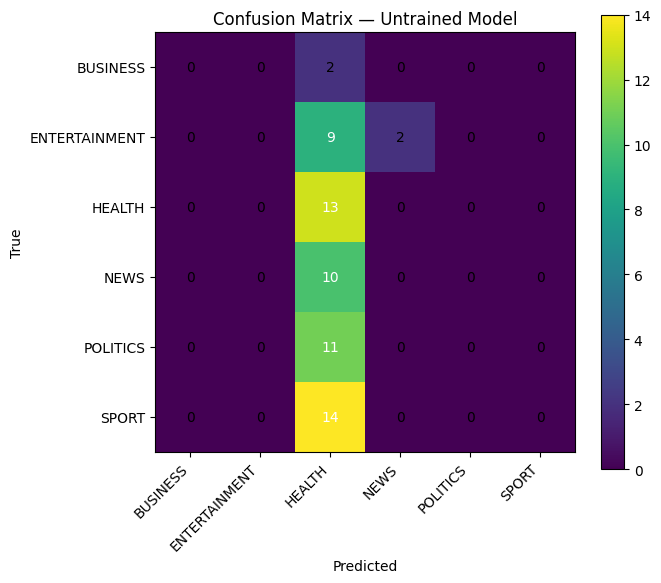

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true_labels_untrained, pred_labels_untrained, labels=list(label2id.keys()))
labels_sorted = list(label2id.keys())

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm)

for i in range(len(labels_sorted)):
    for j in range(len(labels_sorted)):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45, ha="right")
ax.set_yticklabels(labels_sorted)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix — Untrained Model")
plt.colorbar(im)
plt.tight_layout()
plt.show()


##Human Generated News vs AI Generated News

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer

model_path = "/content/drive/MyDrive/cnn_news_bert_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

os.environ['WANDB_DISABLED'] = "true"

/tmp/ipython-input-2700216948.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
excel_path = "/content/drive/MyDrive/News_Test_AI.xlsx"

test_df = pd.read_excel(excel_path)

print(test_df.head())
print(test_df.columns)

                                                text     label
0  A Tectonic Shift in Global Diplomacy as Trade ...  politics
1  Local Startup Secures $150M in Series C Fundin...  business
2  Fourth Quarter Stagnation: A Deep Dive into Ma...  business
3  Marathon Runner Shatters 40-Year-Old Course Re...    sports
4  The New Normal: Navigating the Complexities of...    health
Index(['text', 'label'], dtype='object')


In [ ]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/News_Test_AI.xlsx")

print(df["label"].unique())


['politics' 'business' 'sports' 'health' 'entertainment' 'news']


In [ ]:
test_df = test_df.dropna(subset=["text", "label"])

# Normalize labels
test_df["Label_clean"] = test_df["label"].astype(str).str.strip().str.lower()

# Mapping exactly matches your unique labels
label_name_map = {
    "business": "BUSINESS",
    "entertainment": "ENTERTAINMENT",
    "health": "HEALTH",
    "news": "NEWS",
    "politics": "POLITICS",
    "sports": "SPORT",   # maps correctly
}

# Map to uppercase model labels
test_df["label_name"] = test_df["Label_clean"].map(label_name_map)

# Show unmapped values
unmapped = test_df[test_df["label_name"].isna()]["Label_clean"].unique()
print("UNMAPPED:", unmapped)

# Drop rows with no mapped label
test_df = test_df.dropna(subset=["label_name"])

# Convert label names → numeric IDs
test_df["label"] = test_df["label_name"].map(label2id)

print("Final dataframe shape:", test_df.shape)
print(test_df.head())

UNMAPPED: []
Final dataframe shape: (43, 4)
                                                text  label Label_clean  \
0  A Tectonic Shift in Global Diplomacy as Trade ...      4    politics   
1  Local Startup Secures $150M in Series C Fundin...      0    business   
2  Fourth Quarter Stagnation: A Deep Dive into Ma...      0    business   
3  Marathon Runner Shatters 40-Year-Old Course Re...      5      sports   
4  The New Normal: Navigating the Complexities of...      2      health   

  label_name  
0   POLITICS  
1   BUSINESS  
2   BUSINESS  
3      SPORT  
4     HEALTH  


In [ ]:
external_test_dataset = Dataset.from_pandas(
    test_df[["text", "label"]],
    preserve_index=False,
)

external_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 43
})

In [ ]:
tokenized_external_test = external_test_dataset.map(
    tokenization,
    batched=True,
)

tokenized_external_test


Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 43
})

In [ ]:
ai_metrics = trainer.evaluate(tokenized_external_test)
ai_metrics

{'eval_loss': 0.9182068705558777,
 'eval_model_preparation_time': 0.0027,
 'eval_accuracy': 0.6976744186046512,
 'eval_f1_weighted': 0.6947661094035923,
 'eval_runtime': 0.8638,
 'eval_samples_per_second': 49.782,
 'eval_steps_per_second': 6.946}

In [ ]:
import numpy as np

pred_output = trainer.predict(tokenized_external_test)
logits = pred_output.predictions
pred_ids = np.argmax(logits, axis=-1)

id2label = {v: k for k, v in label2id.items()}

pred_labels = [id2label[i] for i in pred_ids]
true_labels = [id2label[i] for i in test_df["label"].tolist()]

results_df = test_df.copy()
results_df["pred_label"] = pred_labels
results_df["true_label_name"] = true_labels

results_df[["text", "label", "true_label_name", "pred_label"]].head(20)


,text,label,true_label_name,pred_label
0,A Tectonic Shift in Global Diplomacy as Trade ...,4,POLITICS,NEWS
1,Local Startup Secures $150M in Series C Fundin...,0,BUSINESS,BUSINESS
2,Fourth Quarter Stagnation: A Deep Dive into Ma...,0,BUSINESS,BUSINESS
3,Marathon Runner Shatters 40-Year-Old Course Re...,5,SPORT,SPORT
4,The New Normal: Navigating the Complexities of...,2,HEALTH,HEALTH
5,Hollywood’s New Golden Age? How Streaming Wars...,1,ENTERTAINMENT,ENTERTAINMENT
6,Legislative Gridlock Threatens Infrastructure ...,4,POLITICS,POLITICS
7,The Unlikely Championship Run: Underdogs Defy ...,5,SPORT,SPORT
8,New Study Reveals Correlation Between Chronic ...,2,HEALTH,HEALTH
9,The Star Vehicle Paradox: Why the New Generati...,1,ENTERTAINMENT,ENTERTAINMENT


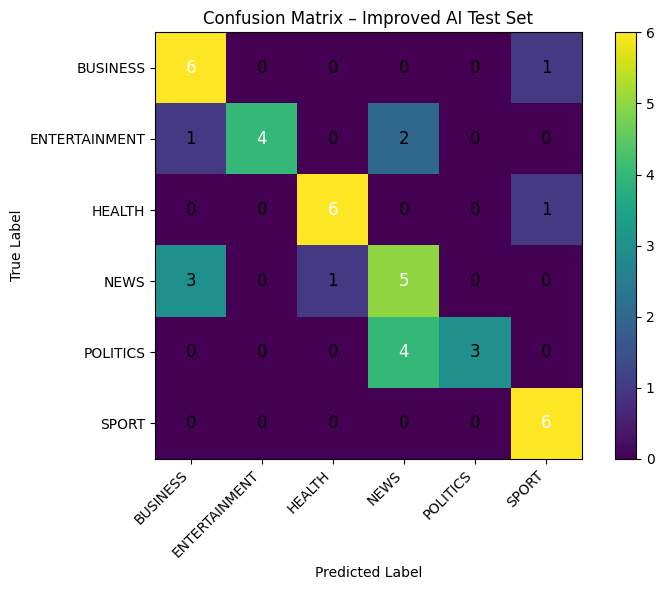

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels_sorted = list(label2id.keys())
cm = confusion_matrix(results_df["true_label_name"], results_df["pred_label"], labels=labels_sorted)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')

for i in range(len(labels_sorted)):
    for j in range(len(labels_sorted)):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=12)

ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45, ha="right")
ax.set_yticklabels(labels_sorted)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix – Improved AI Test Set")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


## Hyper Parameter Changed

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

checkpoint = 'distilbert-base-uncased'
num_labels = 6

id2label = {
    0: 'BUSINESS',
    1: 'ENTERTAINMENT',
    2: 'HEALTH',
    3: 'NEWS',
    4: 'POLITICS',
    5: 'SPORT',
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

os.environ['WANDB_DISABLED'] = "true"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3444624499.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.247400,0.150651,0.959329,0.958165
2,0.094600,0.128606,0.962900,0.962714
3,0.051900,0.147041,0.963055,0.962333


TrainOutput(global_step=2418, training_loss=0.11516484591071521, metrics={'train_runtime': 4237.9277, 'train_samples_per_second': 18.242, 'train_steps_per_second': 0.571, 'total_flos': 1.0241387698231296e+16, 'train_loss': 0.11516484591071521, 'epoch': 3.0})

In [ ]:
external_metrics0 = trainer.evaluate(tokenized_external_test0)
external_metrics0

{'eval_loss': 0.6942281723022461,
 'eval_accuracy': 0.8688524590163934,
 'eval_f1_weighted': 0.8703078681381478,
 'eval_runtime': 0.869,
 'eval_samples_per_second': 70.193,
 'eval_steps_per_second': 2.301,
 'epoch': 3.0}

In [ ]:
import numpy as np

pred_output = trainer.predict(tokenized_external_test0)
logits = pred_output.predictions
pred_ids = np.argmax(logits, axis=-1)

id2label = {v: k for k, v in label2id.items()}
pred_labels = [id2label[i] for i in pred_ids]
true_labels = [id2label[i] for i in df_for_ds["label"].tolist()]

results_df = test_df.copy()
results_df["pred_label"] = pred_labels
results_df["true_label_name"] = [id2label[i] for i in test_df0["label"]]

results_df[["Text", "Label", "true_label_name", "pred_label"]].head(20)


,Text,Label,true_label_name,pred_label
0,LaMelo Ball has stuck with the Charlotte Horne...,sports,SPORT,SPORT
1,CeeDee Lamb says he and fellow Dallas Cowboys ...,sports,SPORT,SPORT
2,"Baylor AD Mack Rhoades resigns, a week after t...",sports,SPORT,SPORT
3,Trump renews effort to block states from regul...,politics,POLITICS,POLITICS
4,Bipartisan push to reform censure process emer...,politics,POLITICS,POLITICS
5,Judge halts Trump’s deployment of national gua...,politics,POLITICS,POLITICS
6,Colombia recovers first treasures from 300-yea...,news,NEWS,NEWS
7,‘Grey’s Anatomy’ star James Pickens Jr. opens ...,entertainment,ENTERTAINMENT,ENTERTAINMENT
8,Meryl Streep reunites with Anne Hathaway in ‘T...,entertainment,ENTERTAINMENT,NEWS
9,They’re making a sequel to ‘The Family Stone’\...,entertainment,ENTERTAINMENT,ENTERTAINMENT


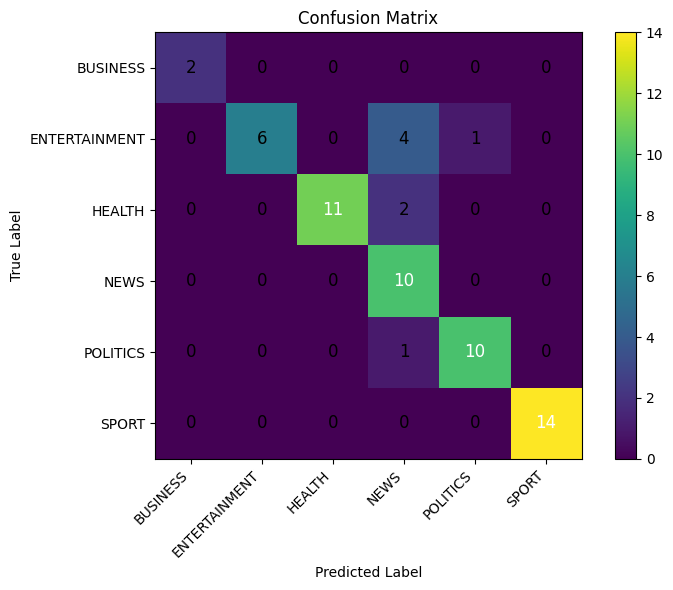

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(true_labels, pred_labels, labels=list(label2id.keys()))
labels_sorted = list(label2id.keys())

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')

for i in range(len(labels_sorted)):
    for j in range(len(labels_sorted)):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=12)

ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45, ha="right")
ax.set_yticklabels(labels_sorted)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

##Post Presentation Adjustments

In [ ]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

checkpoint = 'distilbert-base-uncased'
num_labels = 6

id2label = {
    0: 'BUSINESS',
    1: 'ENTERTAINMENT',
    2: 'HEALTH',
    3: 'NEWS',
    4: 'POLITICS',
    5: 'SPORT',
}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    seed=42,
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

os.environ['WANDB_DISABLED'] = "true"

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2030021133.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hamoui491 (hamoui491-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.161500,0.167463,0.956070,0.954972
2,0.101800,0.160716,0.961813,0.961395
3,0.052700,0.170851,0.964607,0.963936


TrainOutput(global_step=4833, training_loss=0.12317541640613382, metrics={'train_runtime': 4155.5003, 'train_samples_per_second': 18.604, 'train_steps_per_second': 1.163, 'total_flos': 1.0241387698231296e+16, 'train_loss': 0.12317541640613382, 'epoch': 3.0})

In [ ]:
trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.13913299143314362,
 'eval_accuracy': 0.9639338494018297,
 'eval_f1_weighted': 0.9634755683036493,
 'eval_runtime': 92.2405,
 'eval_samples_per_second': 61.622,
 'eval_steps_per_second': 3.859,
 'epoch': 3.0}

In [ ]:
external_metrics = trainer.evaluate(tokenized_external_test0)
external_metrics

{'eval_loss': 0.7456711530685425,
 'eval_accuracy': 0.8688524590163934,
 'eval_f1_weighted': 0.8704735064161909,
 'eval_runtime': 1.1015,
 'eval_samples_per_second': 55.377,
 'eval_steps_per_second': 3.631,
 'epoch': 3.0}